In [1]:
fidx = 'ens'
midx = '53'

import numpy as np
import pickle

# class-specific ensemble weights
weights = pickle.load(open('ens_weights53.pkl','rb'))
print(len(weights))

glist = ['iv3_q11','irv2_q10','resnet_q24','resnet_q25','resnet_q40',
          'gap_q12','nas_q11','se_resnext_q26','bni_q0','bni_q1']

glist += ['iv3_q12','iv3_u11','resnet_q26','resnet_q27',
           'resnet_u25','resnet_u31','resnet_u56','resnet_u101',
           'gap_u14','bni_u1']

# glist = ['iv3_q11','iv3_q12','iv3_u11','irv2_q10',
#          'resnet_q24','resnet_q25','resnet_q26','resnet_q27',
#          'resnet_q40','resnet_u25',
#          'gap_q12','nas_q11','nas_q12',
#          'se_resnext_q26','se_resnext_q28','bni_q0','bni_q1']

28


In [2]:
# list of unique model names
allm = [weights[i]['mod'].values for i in range(len(weights))]
mnames = list(set().union(*allm))
print(mnames)

['bni_q0', 'iv3_q12', 'se_resnext_q26', 'resnet_u31', 'irv2_q10', 'resnet_q40', 'gap_u14', 'resnet_q27', 'gap_q12', 'iv3_u11', 'resnet_u56', 'resnet_q24', 'resnet_u25', 'bni_u1', 'resnet_q25', 'bni_q1', 'iv3_q11', 'resnet_u101', 'nas_q11', 'resnet_q26']


In [3]:
nfold = 20
threshold = 0.34
sub_dir = './sub/'

print(fidx,midx,nfold,len(mnames))

ens 53 20 20


In [4]:

blist = ['blend_0459']
tlist = ['iv3_a4','se_resnext_d10','se_resnext_d11']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(blist)
print(tlist)
print(klist)

gpct = 97.5
gscale = 10.

['iv3_q11', 'irv2_q10', 'resnet_q24', 'resnet_q25', 'resnet_q40', 'gap_q12', 'nas_q11', 'se_resnext_q26', 'bni_q0', 'bni_q1', 'iv3_q12', 'iv3_u11', 'resnet_q26', 'resnet_q27', 'resnet_u25', 'resnet_u31', 'resnet_u56', 'resnet_u101', 'gap_u14', 'bni_u1']
['blend_0459']
['iv3_a4', 'se_resnext_d10', 'se_resnext_d11']
['resnet34_46', 'resnet50', 'resnet34']


In [5]:
import numpy as np
import pandas as pd
import pickle
import os
from os import path
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize

from scipy.special import logit, expit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import jaccard_similarity_score, f1_score

import scipy.optimize as opt

import gc
import cv2
from tqdm import tqdm_notebook

from numpy import inf

/home/sasrdw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
LABEL_MAP = name_label_dict
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [7]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [8]:
# test_df["images"] = [np.array(load_img("images/{}.png".format(idx), \
#                                         color_mode = "grayscale")) / 255. \
#                                         # grayscale=True)) / 255. \
#                       for idx in tqdm_notebook(test_df.index)]
# print(test_df.shape)

In [9]:
test_df.columns

Index(['Predicted'], dtype='object')

In [10]:
# save a base copy for reuse below
test_df0 = test_df.copy()


In [11]:
# build submission ensemble as weighted average on logit scale
test_df = test_df0.copy()
idx = test_df.index.values

firstm = True
sumw = 0.

for m in mnames:

    firstf = True
    if m in blist: suffix = '.npy'
    elif m in klist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['','a','b','c','d','e','f','g','h','i']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                navg = 1
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                navg += 1
    
    if navg == 0: print('Error: No files found')
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)



./sub/bni_q0_0_mm.pkl
0.1396755105922818 0.4042953943504374 0.6159631275234945
(11702, 28) 0.1396755105922818 0.4042953943504374 0.6159631275234945

./sub/bni_q0_1_mm.pkl
0.16671003600531828 0.41625326542417285 0.6367132595613545
(11702, 28) 0.16671003600531828 0.41625326542417285 0.6367132595613545
[[1.    0.911]
 [0.911 1.   ]]

./sub/bni_q0_2_mm.pkl
0.15230293617657936 0.4099399307899474 0.6256008896844845
(11702, 28) 0.15230293617657936 0.4099399307899474 0.6256008896844845
[[1.   0.94]
 [0.94 1.  ]]

./sub/bni_q0_3_mm.pkl
0.16555725523285733 0.4167302630074276 0.6252311956534325
(11702, 28) 0.16555725523285733 0.4167302630074276 0.6252311956534325
[[1.    0.941]
 [0.941 1.   ]]
bni_q0 4 (11702, 28) 0.18050161861430075 0.41180471339299635 0.6124048538898691 0.7967624581878555

./sub/iv3_q12_0_mm.pkl
0.11920292202211755 0.39026531212732607 0.8807970779778823
(11702, 28) 0.11920292202211755 0.39026531212732607 0.8807970779778823

./sub/iv3_q12_1_mm.pkl
0.11920292202211755 0.40346921

In [12]:
test_df.columns

Index(['Predicted', 'bni_q0', 'iv3_q12', 'se_resnext_q26', 'resnet_u31',
       'irv2_q10', 'resnet_q40', 'gap_u14', 'resnet_q27', 'gap_q12', 'iv3_u11',
       'resnet_u56', 'resnet_q24', 'resnet_u25', 'bni_u1', 'resnet_q25',
       'bni_q1', 'iv3_q11', 'resnet_u101', 'nas_q11', 'resnet_q26'],
      dtype='object')

In [13]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [14]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    ff = np.array(list(test_df[c])).flatten()
    print(ff.shape,c)
    f.append(ff)
# print(clist)
r = np.corrcoef(f)
print(r)

(327656,) bni_q0
(327656,) iv3_q12
(327656,) se_resnext_q26
(327656,) resnet_u31
(327656,) irv2_q10
(327656,) resnet_q40
(327656,) gap_u14
(327656,) resnet_q27
(327656,) gap_q12
(327656,) iv3_u11
(327656,) resnet_u56
(327656,) resnet_q24
(327656,) resnet_u25
(327656,) bni_u1
(327656,) resnet_q25
(327656,) bni_q1
(327656,) iv3_q11
(327656,) resnet_u101
(327656,) nas_q11
(327656,) resnet_q26
[[1.    0.937 0.924 0.922 0.954 0.962 0.937 0.949 0.945 0.951 0.901 0.97  0.962 0.973 0.972 0.98
  0.95  0.91  0.918 0.95 ]
 [0.937 1.    0.909 0.89  0.941 0.917 0.916 0.935 0.906 0.936 0.908 0.934 0.927 0.928 0.939 0.937
  0.985 0.914 0.891 0.93 ]
 [0.924 0.909 1.    0.881 0.928 0.913 0.915 0.917 0.924 0.926 0.878 0.927 0.924 0.92  0.928 0.924
  0.924 0.888 0.894 0.907]
 [0.922 0.89  0.881 1.    0.912 0.909 0.897 0.905 0.908 0.905 0.848 0.924 0.926 0.916 0.925 0.913
  0.907 0.861 0.886 0.888]
 [0.954 0.941 0.928 0.912 1.    0.934 0.933 0.929 0.936 0.954 0.887 0.955 0.942 0.947 0.949 0.949
  0.956 0.

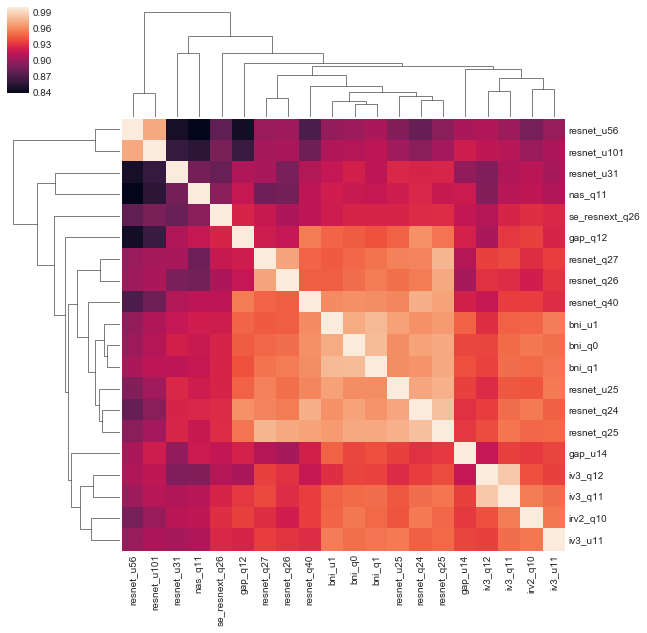

In [15]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [16]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 20)
flat.csv


In [17]:
ens = np.zeros((test_df.shape[0],28))

# apply class-specific ensemble weights
for i in range(28):

    f = []
    clist = weights[i]['mod'].values
    for c in clist:
        f.append(np.array(list(test_df[c])))
    m = np.array(f)
    print(m.shape)

    w = np.array(weights[i]['weight'].values)
    print(i, clist, w)

    ens[:,i] = np.average(m,axis=0,weights=w)[:,i]
    
print(ens.shape)

(5, 11702, 28)
0 ['iv3_q11' 'resnet_q27' 'resnet_u31' 'resnet_u56' 'resnet_u101'] [1 3 2 1 1]
(5, 11702, 28)
1 ['resnet_q27' 'resnet_u25' 'resnet_u31' 'resnet_u56' 'resnet_u101'] [1 2 1 1 2]
(5, 11702, 28)
2 ['iv3_q12' 'resnet_q27' 'resnet_u31' 'resnet_u56' 'resnet_u101'] [3 1 3 1 2]
(5, 11702, 28)
3 ['iv3_q12' 'resnet_q27' 'resnet_u31' 'resnet_u56' 'resnet_u101'] [1 5 6 4 6]
(5, 11702, 28)
4 ['iv3_q12' 'resnet_q27' 'resnet_u25' 'resnet_u31' 'resnet_u56'] [1 2 1 2 3]
(6, 11702, 28)
5 ['iv3_u11' 'resnet_q27' 'resnet_u31' 'resnet_u56' 'resnet_u101' 'gap_u14'] [1 2 8 4 1 1]
(12, 11702, 28)
6 ['irv2_q10' 'resnet_q24' 'bni_q1' 'iv3_q12' 'iv3_u11' 'resnet_q26' 'resnet_q27' 'resnet_u25'
 'resnet_u31' 'resnet_u56' 'resnet_u101' 'bni_u1'] [1 5 1 4 2 2 5 2 2 1 3 1]
(5, 11702, 28)
7 ['iv3_q12' 'resnet_q27' 'resnet_u31' 'resnet_u56' 'resnet_u101'] [2 3 4 2 5]
(3, 11702, 28)
8 ['resnet_u31' 'resnet_u56' 'resnet_u101'] [2 1 1]
(3, 11702, 28)
9 ['resnet_q25' 'resnet_u31' 'resnet_u56'] [1 1 1]
(3, 117

In [18]:
print(ens[1])

[0.496 0.407 0.44  0.476 0.45  0.577 0.473 0.424 0.309 0.273 0.265 0.463 0.404 0.405 0.432 0.32
 0.423 0.379 0.466 0.454 0.352 0.452 0.406 0.446 0.446 0.548 0.458 0.309]


In [19]:
# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# mthresh[mname]

In [20]:
# desired class proportions from lb probing

desired = {
0 : 0.36239782,
1 : 0.043841336,
2 : 0.075268817,
3 : 0.059322034,
4 : 0.075268817,
5 : 0.075268817,
6 : 0.043841336,
7 : 0.075268817,
8 : 0.0018,
9 : 0.0014,
10 : 0.0009,
11 : 0.043841336,
12 : 0.043841336,
13 : 0.014198783,
14 : 0.043841336,
15 : 0.0007,
16 : 0.028806584,
17 : 0.014198783,
18 : 0.028806584,
19 : 0.059322034,
20 : 0.0056,
21 : 0.126126126,
22 : 0.028806584,
23 : 0.075268817,
24 : 0.0104,
25 : 0.222493888,
26 : 0.028806584,
27 : 0.0004
}
print(desired)

{0: 0.36239782, 1: 0.043841336, 2: 0.075268817, 3: 0.059322034, 4: 0.075268817, 5: 0.075268817, 6: 0.043841336, 7: 0.075268817, 8: 0.0018, 9: 0.0014, 10: 0.0009, 11: 0.043841336, 12: 0.043841336, 13: 0.014198783, 14: 0.043841336, 15: 0.0007, 16: 0.028806584, 17: 0.014198783, 18: 0.028806584, 19: 0.059322034, 20: 0.0056, 21: 0.126126126, 22: 0.028806584, 23: 0.075268817, 24: 0.0104, 25: 0.222493888, 26: 0.028806584, 27: 0.0004}


In [21]:
# fixed global threshold
pred = (ens > threshold).astype(int)
print('fixed threshold',threshold)
for j in range(pred.shape[1]):
    prop = np.mean(pred[:,j])
    print(j,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

fixed threshold 0.34
0 0.3624 1.0000 Nucleoplasm
1 0.0438 0.9694 Nuclear membrane
2 0.0753 0.9999 Nucleoli
3 0.0593 0.9986 Nucleoli fibrillar center
4 0.0753 0.9972 Nuclear speckles
5 0.0753 0.9996 Nuclear bodies
6 0.0438 0.9666 Endoplasmic reticulum
7 0.0753 0.9989 Golgi apparatus
8 0.0018 0.0572 Peroxisomes
9 0.0014 0.0297 Endosomes
10 0.0009 0.0179 Lysosomes
11 0.0438 0.9934 Intermediate filaments
12 0.0438 0.8728 Actin filaments
13 0.0142 0.8910 Focal adhesion sites
14 0.0438 0.9177 Microtubules
15 0.0007 0.1557 Microtubule ends
16 0.0288 0.9795 Cytokinetic bridge
17 0.0142 0.7678 Mitotic spindle
18 0.0288 0.9973 Microtubule organizing center
19 0.0593 0.9994 Centrosome
20 0.0056 0.5150 Lipid droplets
21 0.1261 0.9989 Plasma membrane
22 0.0288 0.9393 Cell junctions
23 0.0753 0.9999 Mitochondria
24 0.0104 0.5662 Aggresome
25 0.2225 0.9999 Cytosol
26 0.0288 0.8615 Cytoplasmic bodies
27 0.0004 0.0709 Rods & rings


In [22]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

from scipy.special import expit

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

pred_t = expit(ens)
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
np.set_printoptions(precision=3, suppress=True, linewidth=100)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))
pred = (pred_t > th_t).astype(int)

Thresholds:  [1.286 2.624 2.916 2.899 2.846 2.956 2.811 2.947 1.163 1.026 0.658 2.892 2.389 2.403 2.414 1.239
 2.926 2.226 3.057 2.998 1.696 2.748 2.56  2.958 1.776 1.682 2.305 1.223]
Fractions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Fractions (th = 0.5):  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
# custom thresholds to match lb proportions
thresholds = np.linspace(0.9, 0.1, 100001)
pred = ens.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (ens[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= desired[j]: break
    print(j,'%6.4f' % t,'%6.4f' % desired[j],'%6.4f' % prop,name_label_dict[j],)

0 0.5567 0.3624 0.3624 Nucleoplasm
1 0.5265 0.0438 0.0439 Nuclear membrane
2 0.5578 0.0753 0.0753 Nucleoli
3 0.5021 0.0593 0.0594 Nucleoli fibrillar center
4 0.4949 0.0753 0.0753 Nuclear speckles
5 0.5109 0.0753 0.0753 Nuclear bodies
6 0.5199 0.0438 0.0439 Endoplasmic reticulum
7 0.5213 0.0753 0.0753 Golgi apparatus
8 0.4302 0.0018 0.0019 Peroxisomes
9 0.4655 0.0014 0.0015 Endosomes
10 0.4694 0.0009 0.0009 Lysosomes
11 0.5223 0.0438 0.0439 Intermediate filaments
12 0.5007 0.0438 0.0439 Actin filaments
13 0.5392 0.0142 0.0143 Focal adhesion sites
14 0.5515 0.0438 0.0440 Microtubules
15 0.4913 0.0007 0.0008 Microtubule ends
16 0.5275 0.0288 0.0290 Cytokinetic bridge
17 0.5421 0.0142 0.0143 Mitotic spindle
18 0.5339 0.0288 0.0289 Microtubule organizing center
19 0.5210 0.0593 0.0594 Centrosome
20 0.5102 0.0056 0.0056 Lipid droplets
21 0.5427 0.1261 0.1261 Plasma membrane
22 0.5275 0.0288 0.0289 Cell junctions
23 0.5395 0.0753 0.0753 Mitochondria
24 0.5313 0.0104 0.0104 Aggresome
25 0.5580

In [24]:
np.set_printoptions(linewidth=100)
print(pred[:5].astype(int))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [25]:
xps = np.sum(pred,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(11702,)
0.0 1.591693727567937 5.0


In [26]:
print(sum(xps==0)/pred.shape[0])

0.08254999145445223


In [27]:
subs = []
ids = []
for i,fid in enumerate(test_df.index.values):
    subrow = ' '.join(list([str(i) for i in np.nonzero(pred[i])[0]]))
    subs.append(subrow)
    ids.append(fid)
    if i % 1000 == 0: print(i,fid,subrow)
print({'ids':ids[:10], 'subs':subs[:10]})
print(len(ids), len(subs))

0 00008af0-bad0-11e8-b2b8-ac1f6b6435d0 2
1000 15efe29e-bad4-11e8-b2b8-ac1f6b6435d0 20 26
2000 2bd51caa-bad9-11e8-b2b9-ac1f6b6435d0 24
3000 42f7f174-bace-11e8-b2b8-ac1f6b6435d0 0
4000 589b3070-bad0-11e8-b2b8-ac1f6b6435d0 3 4
5000 6dd7e7b6-bac7-11e8-b2b7-ac1f6b6435d0 
6000 835f7a30-bad7-11e8-b2b9-ac1f6b6435d0 2 23
7000 9932fa46-bac6-11e8-b2b7-ac1f6b6435d0 21 25
8000 aeabe93c-bacb-11e8-b2b8-ac1f6b6435d0 1
9000 c4ad1a3a-bada-11e8-b2b9-ac1f6b6435d0 11
10000 da851aec-bada-11e8-b2b9-ac1f6b6435d0 0 21 25
11000 f071ee12-bad9-11e8-b2b9-ac1f6b6435d0 12 19 21
{'ids': ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0', '0000a892-bacf-11e8-b2b8-ac1f6b6435d0', '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0', '0008baca-bad7-11e8-b2b9-ac1f6b6435d0', '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0', '00109f6a-bac8-11e8-b2b7-ac1f6b6435d0', '001765de-bacd-11e8-b2b8-ac1f6b6435d0', '0018641a-bac9-11e8-b2b8-ac1f6b6435d0', '00200f22-bad7-11e8-b2b9-ac1f6b6435d0', '0026f154-bac6-11e8-b2b7-ac1f6b6435d0'], 'subs': ['2', '5', '0 5 25', '0', ''

In [28]:
subm = pd.DataFrame.from_dict({'Id':ids, 'Predicted':subs}, orient='index').T
fname = 'sub/' + fidx + midx + '.csv'
subm.to_csv(fname, index=False)
print(fname)

sub/ens53.csv


In [29]:
from itertools import chain
from collections import Counter
max_idx = 27
subm['target_list'] = subm['Predicted'].map(lambda x: \
            [int(a) if a != '' else -1 for a in str(x).split(' ')])
subm['target_vec'] = subm['target_list'].map(lambda ck: \
            [i in ck for i in range(max_idx+1)])
all_labels = list(chain.from_iterable(subm['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
for k,v in name_label_dict.items():
    print(k,v, 'count', c_val[k] if k in c_val else 0,
             'prop', '%6.4f' % (c_val[k]/len(ids) if k in c_val else 0))

0 Nucleoplasm count 4241 prop 0.3624
1 Nuclear membrane count 514 prop 0.0439
2 Nucleoli count 881 prop 0.0753
3 Nucleoli fibrillar center count 695 prop 0.0594
4 Nuclear speckles count 881 prop 0.0753
5 Nuclear bodies count 881 prop 0.0753
6 Endoplasmic reticulum count 514 prop 0.0439
7 Golgi apparatus count 881 prop 0.0753
8 Peroxisomes count 22 prop 0.0019
9 Endosomes count 17 prop 0.0015
10 Lysosomes count 11 prop 0.0009
11 Intermediate filaments count 514 prop 0.0439
12 Actin filaments count 514 prop 0.0439
13 Focal adhesion sites count 167 prop 0.0143
14 Microtubules count 515 prop 0.0440
15 Microtubule ends count 9 prop 0.0008
16 Cytokinetic bridge count 339 prop 0.0290
17 Mitotic spindle count 167 prop 0.0143
18 Microtubule organizing center count 338 prop 0.0289
19 Centrosome count 695 prop 0.0594
20 Lipid droplets count 66 prop 0.0056
21 Plasma membrane count 1476 prop 0.1261
22 Cell junctions count 338 prop 0.0289
23 Mitochondria count 881 prop 0.0753
24 Aggresome count 122 

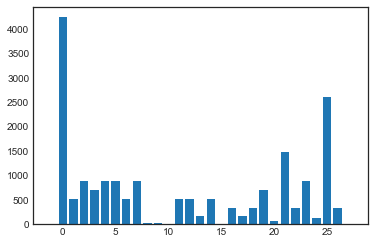

In [30]:
train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
_ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [31]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


# computute confusion matrices between two submission files
def f1_confusion(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
    
    y0avg = np.average(y0,axis=0)
    y1avg = np.average(y1,axis=0)
    cm = [confusion_matrix(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    fm = [f1_score(y0[:,i], y1[:,i]) for i in range(y0.shape[1])]
    for i in range(y0.shape[1]):
        print(LABEL_MAP[i])
        print(cm[i],' %4.2f' % fm[i],' %6.4f' % y0avg[i],' %6.4f' % y1avg[i],
             ' %6.4f' % (y0avg[i] - y1avg[i]))
        print()
#     print('y0avg')
#     print(y0avg)
#     print('y1avg')
#     print(y1avg)
#     print('y0avg - y1avg')
#     print(y0avg-y1avg)
    print('f1 macro')
    print(np.mean(fm))       
    return f1_score(y0, y1, average='macro')
    
# compute f1 score between two submission files
def f1_sub(csv0, csv1, num_classes=28):
    c0 = pd.read_csv(csv0)
    c1 = pd.read_csv(csv1)
    assert c0.shape == c1.shape
    s0 = [s if isinstance(s,str) else '' for s in c0.Predicted]
    s1 = [s if isinstance(s,str) else '' for s in c1.Predicted]
    p0 = [s.split() for s in s0]
    p1 = [s.split() for s in s1]
    y0 = np.zeros((c0.shape[0],num_classes)).astype(int)
    y1 = np.zeros((c0.shape[0],num_classes)).astype(int)
    # print(p0[:5])
    for i in range(c0.shape[0]):
        for j in p0[i]: y0[i,int(j)] = 1
        for j in p1[i]: y1[i,int(j)] = 1
    # print(y0[:5])
            
    return f1_score(y0, y1, average='macro')

In [32]:
f1_sub(fname,'sub/protein_classification.csv')

0.6018446586386005

In [33]:
f1_sub(fname,'sub/submit_InceptionV3.csv')

0.5517434832675369

In [34]:
f1_sub(fname,'sub/submit_InceptionResNetV2_3.csv')

0.5346147947799359

In [35]:
f1_sub(fname,'sub/blend_InceptionV3_InceptionResNetV2_DenseNet201_2.csv')

0.60856179664638

In [36]:
f1_sub(fname,'sub/iv3_0.csv')

0.5847751320998711

In [37]:
f1_sub(fname,'sub/irv2_0.csv')

0.597994852318233

In [38]:
f1_sub(fname,'sub/resnet34_0.csv')

0.6241515987050371

In [39]:
f1_sub(fname,'sub/resnet50_0.csv')

0.6280322070023027

In [40]:
f1_sub(fname,'sub/resnet4.csv')

0.6484382762806622

In [41]:
f1_sub(fname,'sub/resnet5.csv')

0.6099788061821952

In [42]:
f1_sub(fname,'sub/resnet6.csv')

0.654567593538642

In [43]:
f1_sub(fname,'sub/resnet7.csv')

0.6271214093428744

In [44]:
f1_sub(fname,'sub/se_resnet1.csv')

0.628960464338325

In [45]:
f1_sub(fname,'sub/se_resnet2.csv')

0.6400937997525151

In [46]:
f1_sub(fname,'sub/se_resnext6.csv')

0.5892655088370441

In [47]:
f1_sub(fname,'sub/se_resnext9.csv')

0.6063311801466821

In [48]:
f1_sub(fname,'sub/ens0.csv')

0.6180996411239714

In [49]:
f1_sub(fname,'sub/ens1.csv')

0.6397822440056753

In [50]:
f1_sub(fname,'sub/ens2.csv')

0.6357421270756944

In [51]:
f1_sub(fname,'sub/ens6.csv')

0.6731820462597566

In [52]:
f1_sub(fname,'sub/ens7.csv')

0.6485666447102163

In [53]:
f1_sub(fname,'sub/ens8.csv')

0.7218943301545876

In [54]:
f1_sub(fname,'sub/ens9.csv')

0.7249952264483035

In [55]:
f1_sub(fname,'sub/ens10.csv')

0.7451476873169305

In [56]:
f1_sub(fname,'sub/ens11.csv')

0.7489331538118139

In [57]:
f1_sub(fname,'sub/ens12.csv')

0.7530665317436239

In [58]:
f1_sub(fname,'sub/ens13.csv')

0.6172464285543633

In [59]:
f1_sub(fname,'sub/ens14.csv')

0.7227956105479827

In [60]:
f1_sub(fname,'sub/ens15.csv')

0.7201048450640578

In [61]:
f1_sub(fname,'sub/ens16.csv')

0.7497243679898478

In [62]:
f1_sub(fname,'sub/ens17.csv')

0.7353933709772846

In [63]:
f1_sub(fname,'sub/ens18.csv')

0.7498005919932696

In [64]:
f1_sub(fname,'sub/ens19.csv')

0.7415659561313946

In [65]:
f1_sub(fname,'sub/ens20.csv')

0.7064259921216849

In [66]:
f1_sub(fname,'sub/ens21.csv')

0.7029426942440612

In [67]:
f1_sub(fname,'sub/ens22.csv')

0.7577970989007442

In [68]:
f1_sub(fname,'sub/ens23.csv')

0.76570673893207

In [69]:
f1_sub(fname,'sub/ens24.csv')

0.7546950218117143

In [70]:
f1_sub(fname,'sub/ens25.csv')

0.7544454565082461

In [71]:
f1_sub(fname,'sub/ens26.csv')

0.7523168258229608

In [72]:
f1_sub(fname,'sub/ens27.csv')

0.747056279834362

In [73]:
f1_sub(fname,'sub/ens28.csv')

0.7664000405328475

In [74]:
f1_sub(fname,'sub/ens31.csv')

0.7647853255702967

In [75]:
f1_sub(fname,'sub/ens32.csv')

0.7478961720497003

In [76]:
f1_sub(fname,'sub/ens33.csv')

0.7662771558837688

In [77]:
f1_sub(fname,'sub/ens34.csv')

0.7609886595382566

In [78]:
f1_sub(fname,'sub/ens35.csv')

0.7542256746250032

In [79]:
f1_sub(fname,'sub/ens36.csv')

0.7657004636581618

In [80]:
f1_sub(fname,'sub/ens36.csv')

0.7657004636581618

In [81]:
f1_sub(fname,'sub/ens43.csv')

0.8105618304056713

In [82]:
f1_sub(fname,'sub/ens44.csv')

0.8035774578462516

In [83]:
f1_sub(fname,'sub/ens45.csv')

0.8049230593800455

In [84]:
f1_sub(fname,'sub/ens46.csv')

0.7817738316917057

In [85]:
f1_sub(fname,'sub/ens47.csv')

0.8086458330095504

In [86]:
f1_sub(fname,'sub/ens48.csv')

0.8113193050229569

In [87]:
f1_sub(fname,'sub/ens49.csv')

0.8120059683615651

In [88]:
f1_sub(fname,'sub/resnet11.csv')

0.7353299309773967

In [89]:
f1_sub(fname,'sub/resnet12.csv')

0.7608487131240723

In [90]:
f1_sub(fname,'sub/resnet13.csv')

0.77663966899999

In [91]:
f1_sub(fname,'sub/resnet14.csv')

0.7484496814694135

In [96]:
f1_sub(fname,'sub/resnet15.csv')

0.8510515772990557

In [97]:
f1_sub(fname,'sub/resnet16.csv')

0.7321914284244198

In [92]:
print(fname)

sub/ens53.csv


In [93]:
# f1_confusion(fname, 'sub/ens19.csv')

In [94]:
# f1_confusion(fname, 'sub/ens21.csv')

In [95]:
# f1_confusion(fname, 'sub/ens22.csv')